# CNNの可視化 (Class Activation Mapping; CAM)

---

## 目的
Class Activation Mapping (CAM)の仕組みを理解する.

CAMを用いてCIFAR-10データセットに対するネットワークの判断根拠の可視化を行う．

## Class Activation Mapping (CAM)
Class Activation Mapping (CAM)[1]とは，ネットワークの出力に対する全結合層の結合重みを用いて，ネットワークの推論時における貢献度の高い領域をClass Activation Map (Attention map) として可視化することができる手法です．
まず，入力画像をネットワークに入力して特徴マップを獲得します．
次に，獲得した特徴マップに対してGlobal Average Pooling (GAP)[2]を行い，各特徴マップの空間方向に対する平均値を算出します．
GAPとは，特徴マップの各チャネルごとに空間方向に対する平均値を算出し，その平均値を各特徴マップの値とする処理です．
これにより，全結合層におけるパラメータ数を大幅に削減することができます．
一方で，空間的な情報が失われてしまうというデメリットもあります．
このGlobal Average Poolingによって得られた各チャネルに対する平均値を全結合層のユニットの応答値として最終的な認識結果を出力します．
最後に，畳み込み層で得られた特徴マップと特定のクラスにおける特徴マップの各チャネルに対応する全結合層の結合重みを乗算し，乗算した特徴マップを全て加算することで，Attention mapを獲得します．
クラス$c$に対するAttention mapは，以下の式のように表すことができます．

$$M_c(x,y)=\sum_{k}w^{c}_{k}f_{k}(x,y)$$

ここで，$M_c$はクラス$c$に対するAttention map，$w^{c}_{k}$はクラス$c$の$k$番目の特徴マップに対する結合重み，$f_{k}(x,y)$は$k$番目の特徴マップを示しています．

<img src="https://drive.google.com/uc?export=view&id=10yN9GxNp34WNlUDWNoCToW60cEUbsJFV" width=100%>




## モジュールのインポート
プログラムの実行に必要なモジュールをインポートします．
今回は，機械学習ライブラリであるPytorchを使用します．
PyTorchとは，Python向けのオープンソース機械学習ライブラリで，Facebookに開発されました．

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
import torchsummary

## GPUの確認
GPUを使用した計算が可能かどうかを確認します．
下記のコードを実行してGPU情報を確認します． GPUの確認を行うためには，上部のメニューバーの「ランタイム」→「ランタイムのタイプを変更」からハードウェアアクセラレータをGPUにしてください．

`Use CUDA: True`と表示されれば，GPUを使用した計算をPytorchで行うことが可能です． CPUとなっている場合は，上記に記載している手順にしたがって，設定を変更してください．

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_cuda = torch.cuda.is_available()
cudnn.benchmark = True
print('Use CUDA:', use_cuda)

Use CUDA: True


下記のコードを実行してGPU情報を確認します．



In [3]:
!nvidia-smi

Sat Feb  6 06:08:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 207...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 21%   26C    P8    15W / 215W |      3MiB /  7982MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 207...  Off  | 00000000:1B:00.0 Off |                  N/A |
| 20%   

## 使用するデータセット

### データセット
今回の物体認識では，CIFAR-10データセットを使用します．CIFAR-10データセットは，飛行機や犬などの10クラスの物体が表示されている画像から構成されたデータセットです．

![CIFAR10_sample.png](https://qiita-image-store.s3.ap-northeast-1.amazonaws.com/0/176458/b6b43478-c85f-9211-7bc6-227d9b387af5.png)

### データセットのダウンロードと読み込み
実験に使用するCIFAR-10データセットを読み込みます．
１回の誤差を算出するデータ数 (ミニバッチサイズ) は，4とします．
まず，CIFAR-10データセットをダウンロードします．
次に，ダウンロードしたデータセットを読み込みます．
学習には，大量のデータを利用しますが，それでも十分ではありません． そこで，データ拡張 (data augmentation) により，データのバリエーションを増やします． 一般的な方法は，画像の左右反転，明るさ変換などです． また，画像の一部にマスク処理をかけるRandom Erasingも行います．

In [4]:
batch_size = 4

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    transforms.RandomErasing(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=20)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=20)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### CIFAR-10データセットの表示
CIFAR-10データセットに含まれる画像を表示してみます．
ここでは，matplotlibを用いて複数の画像を表示させるプログラムを利用します．
学習データは5万枚，1つのデータサイズは3x32x32の画像のような形式となっています． これは32x32ピクセルのカラー画像という意味になります．



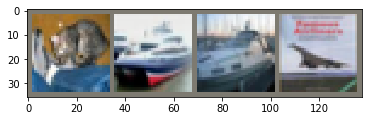

  cat  ship  ship plane


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    npimg = ((npimg.transpose((1,2,0))  * [0.2023, 0.1994, 0.2010]) + [0.4914, 0.4822, 0.4465])  # unnormalize
    plt.imshow(npimg)
    plt.show()

# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[0:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## ネットワークモデルの定義
次に，CAMを定義します．
今回は，CNNにCAMを導入したモデル (CAM) を使用します．

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import math

class CAM(nn.Module):
    def __init__(self):
        super(CAM, self).__init__()
        num_classes = 10

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.gap = nn.AvgPool2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))

        self.attmap = x
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x, [self.attmap, self.fc.weight]

model = CAM()
model.to(device)

CAM(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (gap): AvgPool2d(kernel_size=16, stride=16, padding=0)
  (relu): ReLU(inplace=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

## 損失関数と最適化手法の定義
学習に使用する損失関数と最適化手法を定義します．
今回は，分類問題を扱うため，クロスエントロピー誤差を計算するための`CrossEntropyLoss`を`criterion`として定義します．
最適化手法には，Adamを用いて学習を行います．
最後に，定義したネットワークの詳細情報を`torchsummary.summary()`関数を用いて表示します．

In [7]:
import torch.optim as optim
from torch.optim import SGD, lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9,  weight_decay=5e-4)

# モデルの情報を表示
torchsummary.summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 32, 32, 32]           9,248
              ReLU-4           [-1, 32, 32, 32]               0
         MaxPool2d-5           [-1, 32, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          36,992
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,584
             ReLU-11          [-1, 128, 16, 16]               0
        AvgPool2d-12            [-1, 128, 1, 1]               0
           Linear-13                   [-1, 10]           1,290
Total params: 343,594
Trainable params:

## 学習
読み込んだCIFAR-10データセットと作成したネットワークを用いて，学習を行います．
今回は，学習エポック数を20とします．
1エポック学習するごとに学習したモデルを評価し，最も認識精度の高いモデルが保存されます．
各更新において，学習用データと教師データをそれぞれ`inputs`と`targets`とします．
学習モデルに`inputs`を与えて，ネットワークの出力とAttention mapを取得します．
ネットワークの出力は教師ラベル`targets`との誤差を`criterion`で算出します．
また，認識精度も算出します．
そして，誤差をbackward関数で逆伝播し，ネットワークの更新を行います．
認識精度も同時に計算して，`print`関数で学習経過における誤差や認識精度を表示します．


In [8]:
epochs = 20
best_acc = 0  # best test accuracy

for epoch in range(epochs):
    train_running_loss = 0.0
    train_running_acc = 0.0

    # training
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    count = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs, _ = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        # print statistics
        train_running_loss += loss
        train_running_acc += 100.*correct/total
        count += 1

    print('[Epoch %d] Train Loss: %.5f | Train Acc: %.3f%%'
                  % (epoch + 1, train_loss/count, train_running_acc/count))

    # testing
    model.eval() 
    with torch.no_grad():
        test_running_loss = 0.0
        test_running_acc = 0.0
        test_loss = 0
        correct = 0
        total = 0
        count = 0
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs, _ = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # print statistics
            test_running_loss += loss
            test_running_acc += 100.*correct/total
            count += 1

        print('Test Loss: %.5f | Test Acc: %.3f%%'
                      % (test_loss/count, test_running_acc/count))
        
    # save model
    if test_running_acc/count > best_acc:
        best_acc = max(test_running_acc/count, best_acc)
        PATH = './cifar_net.pth'
        torch.save(model.state_dict(), PATH)
    
print('Finished Training')

[Epoch 1] Train Loss: 1.70403 | Train Acc: 26.687%
Test Loss: 1.47483 | Test Acc: 47.824%
[Epoch 2] Train Loss: 1.31764 | Train Acc: 49.984%
Test Loss: 1.19251 | Test Acc: 57.593%
[Epoch 4] Train Loss: 1.02148 | Train Acc: 63.094%
Test Loss: 0.94613 | Test Acc: 67.720%
[Epoch 5] Train Loss: 0.94710 | Train Acc: 66.389%
Test Loss: 0.91206 | Test Acc: 69.240%
[Epoch 6] Train Loss: 0.89878 | Train Acc: 67.973%
Test Loss: 0.80132 | Test Acc: 73.314%
[Epoch 7] Train Loss: 0.85403 | Train Acc: 70.428%
Test Loss: 0.79368 | Test Acc: 74.163%
[Epoch 8] Train Loss: 0.82010 | Train Acc: 71.561%
Test Loss: 0.78156 | Test Acc: 73.773%
[Epoch 9] Train Loss: 0.79375 | Train Acc: 72.558%
Test Loss: 0.74260 | Test Acc: 74.840%
[Epoch 10] Train Loss: 0.77694 | Train Acc: 73.522%
Test Loss: 0.71203 | Test Acc: 76.681%
[Epoch 11] Train Loss: 0.75839 | Train Acc: 74.070%
Test Loss: 0.76587 | Test Acc: 74.413%
[Epoch 12] Train Loss: 0.74646 | Train Acc: 74.529%
Test Loss: 0.74407 | Test Acc: 75.960%
[Epoch 

##テスト
学習したネットワークのテストデータに対する認識精度の確認を行います．
まず，学習したネットワークを評価するために保存したモデルをロードします．

In [9]:
model = CAM()
model.to(device)
PATH = './cifar_net.pth'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

次に，学習したネットワークを用いて，テストデータに対する認識精度の確認を行います．
`model.eval()`を適用することで，ネットワーク演算を評価モードへ変更します． これにより，学習時と評価時で挙動が異なる演算（dropout等）を変更することが可能です． また，`torch.no_grad()`を適用することで，学習時には必要になる勾配情報を保持することなく演算を行います．

In [10]:
model.eval()

running_loss = 0.0
running_acc = 0.0
test_loss = 0
correct = 0
total = 0
count = 0

with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs, _ = model(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # print statistics
        running_loss += loss
        running_acc += 100.*correct/total
        count += 1

    print('Test Loss: %.5f | Test Acc: %.3f%%'
                  % (test_loss/count, running_acc/count))

Test Loss: 0.66557 | Test Acc: 78.632%


## CAMによるAttention mapの可視化
出力されたクラス確率の上位5クラスに対するAttention mapを可視化して，ネットワークの判断根拠を確認してみます．
再度，実行することで他のテストサンプルに対するAttention mapを可視化することができます．
pred (prediction) は認識結果，conf (confidence) は認識結果に対する信頼度を示しています．

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


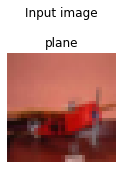

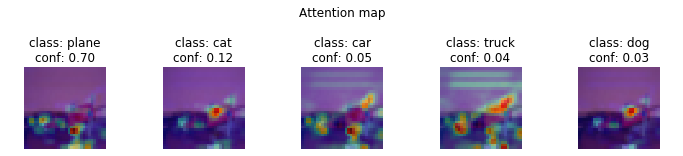

In [11]:
import cv2
from ipykernel import kernelapp as app

testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=True, num_workers=20)

classes_list = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

softmax = nn.Softmax(dim=1)

def min_max(x, axis=None):
    x_min = x.min(axis=axis, keepdims=True)
    x_max = x.max(axis=axis, keepdims=True)
    return (x - x_min) / (x_max - x_min)

with torch.no_grad():
    v_list = []
    att_list = []
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs, attention = model(inputs)
        outputs = softmax(outputs)
        d_inputs = inputs.data.cpu()
        d_inputs = d_inputs.numpy()

        in_b, in_c, in_y, in_x = inputs.shape
        item_img = d_inputs[0]
        v_img = ((item_img.transpose((1, 2, 0)) * [0.2023, 0.1994, 0.2010]) + [0.4914, 0.4822, 0.4465]) * 255
        v_img = np.uint8(v_img)

        # Class Activation Mapping
        out_put = outputs.data.topk(5, 1, True, True)
        top5_score, top5_idx = out_put
        top5_idx = top5_idx.cpu()
        top5_idx = top5_idx.numpy()
        maps, vecs = attention

        for idx_rank, item_rank in enumerate(top5_idx[0]):
            contributes = vecs[item_rank]
            vis_maps = maps[0] * contributes.reshape(contributes.shape[0], 1, 1)
            vis_maps = vis_maps.data.cpu()
            vis_maps = vis_maps.numpy()
            sum_map = np.sum(vis_maps, axis=0)

            resize_map = cv2.resize(sum_map, (in_x, in_y))
            resize_map = min_max(resize_map)
            resize_map *= 255.
            resize_map = np.uint8(resize_map)

            jet_map = cv2.applyColorMap(resize_map, cv2.COLORMAP_JET)
            jet_map = cv2.addWeighted(v_img, 0.6, jet_map, 0.4, 0)
            v_list.append(v_img)
            att_list.append(jet_map)
        break

# Show attention map
cols = 1
rows = 1

fig = plt.figure(figsize=(14, 2.0))
plt.axis("off")
for r in range(rows):
    for c in range(cols):
        cls = targets[c].item()
        ax = fig.add_subplot(r+1, cols, c+1)
        plt.title('Input image\n\n{}'.format(classes_list[cls]))
        ax.imshow(v_list[cols * r + c])
        ax.set_axis_off()
plt.show()

a_cols = 5
a_rows = 1

fig = plt.figure(figsize=(12, 1.5))
plt.title('Attention map\n\n\n')
plt.axis("off")
for r in range(a_rows):
    for c in range(a_cols):
        cls = top5_idx[0][c].item()
        conf = top5_score[0][c]
        ax = fig.add_subplot(r+1, a_cols, c+1)
        plt.title('class: {}\nconf: {:.2f}'.format(classes_list[cls], conf))
        ax.imshow(att_list[a_cols * r + c])
        ax.set_axis_off()
plt.show()

#課題
1. ハイパーパラメータ (学習率，エポック数，ミニバッチサイズ等) を変更して，Attention mapの変化を確認してみましょう．

In [12]:
#ここにコードを書く

# 参考文献
- [1] B. Zhou, A. Khosla, A. Lapedriza, A. Oliva,
and A. Torralba, "Learning deep features for discriminative
localization". In 2016 IEEE Conference on Computer
Vision and Pattern Recognition, pp. 2921–2929, 2016.

- [2] M. Lin, Q. Chen, and S. Yan, "Network in network".
In 2nd International Conference on Learning Representations,
Banff, AB, Canada, April 14-16, 2014, Conference
Track Proceedings, 2014.